In [126]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import itertools
import spacy
import nltk
%matplotlib inline

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [128]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

In [129]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [130]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [131]:
# dataframe display options
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 200)

# Problem Definition
<img src='form2.png'>

> The Objective of the project is to use Natural Language Processing on two fields entered by the user ("event title" and "additional info") to guide the user into selecting the correct category.
+ **"Event type" (category)** is a key field used by the company to match events and the capabilities of their pool of photographers.

# Problem Definition

Classification task: Predicting discrete-valued quantity $y$
+ Multi-class $ y \in \{1,2,3 \ldots k\}$ 


# Data Acquisition

<img src='data.png'>

In order to validate the possibility of a project I scraped information on 100 events. Links to the events were provided by the company.

In [699]:
def search_titles(df, expression):
    categories = df[df['category'].str.contains(expression, regex=True) == True]['category']
    idxs = df[df['category'].str.contains(expression, regex=True) == True].index
    print(categories)
    return idxs

def update_category(df, indices, category_title):
    for i in indices:
        df.loc[i, 'category'] = category_title

In [702]:
b = search_titles(g, r'baptism')

Series([], Name: category, dtype: object)


In [125]:
update_category(g, b, 'life celebration')

## After Categories were regrouped

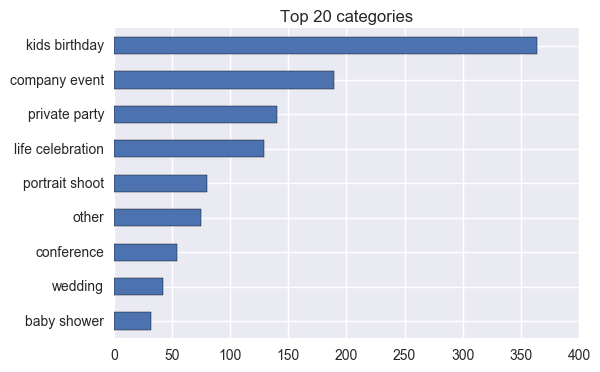

In [150]:
g['category'].value_counts()[:20][::-1].plot(kind='barh');
plt.title("Top 20 categories");

In [728]:
## Pickle data after cleanup
with open('events.pickle', 'wb') as f:
    pickle.dump(g, f)

In [201]:
reset -fs

# Loading events dataframe from pickled object

In [8]:
with open('events.pickle', 'rb') as f:
    g = pickle.load(f) 

In [9]:
categories = g.category.unique()
print("Number of categories: {}".format(len(categories)))

Number of categories: 9


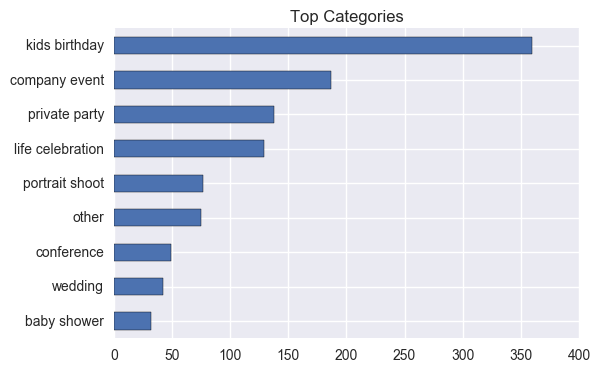

In [10]:
g['category'].value_counts()[:20][::-1].plot(kind='barh');
plt.title("Top Categories");

In [11]:
g['category'].value_counts()[:20]

kids birthday       360
company event       187
private party       138
life celebration    129
portrait shoot      77 
other               75 
conference          49 
wedding             42 
baby shower         32 
Name: category, dtype: int64

In [12]:
g.tail()

,album_ptr_id,title,additional_info,category,id
1100,560606.0,california cannabis industry association,"staged photographer for a step and repeat section, then scrolling photography after that.",company event,d2651246d360450aa29f3cb58b0ef6a8
1101,562327.0,arian's 1st birthday,NaN,kids birthday,08a7e7a3a3294f148aeb606777a7f552
1102,562452.0,nikhil's first birthday,NaN,kids birthday,27d88c2e30f34e32b6a1636ee2d18d17
1103,562658.0,krish and ishan birthday bash,"birthday party of a 2 year old and a 5 year old boys. some family portraits, solo of birthday kids, decorations, photo also with grandparents (focus on them a bit), focus on kids together too, cake cutting & family portraits in front of cake, theme of birthday party is bubbles! professional bubble maker will be there and would love photos of this",kids birthday,aa03bc2d11b443978a5d40dd7eb46253
1104,567831.0,a to z,this is an informal reception at our apartment complex before we have a wedding. we would like to spend the first 1-2 hours on portraits of just the two of us at nice spots around our apartment complex or any other ideas you have. we would like some nice portraits. then capture a bit of the event.,life celebration,76fb502fff584f0da0e812a449bd44be


# EDA

In [13]:
length = g[['title', 'additional_info', 'category']].copy()

In [14]:
length['title'][0]

'mustache movember eversnap party'

### How many characters are in "title" and "additional_info"?

In [53]:
length['title_length'] = length['title'].map(lambda text: len(str(text)))
length.head()

,title,additional_info,category,title_length
0,mustache movember eversnap party,step and repeat banner shots plus party photos,private party,32
1,shilpi's baby shower,NaN,other,20
2,"caleb's cat in the hat"" 1st birthday at superf...",NaN,kids birthday,53
3,michele's bridal shower,"this is the club house at sorrento, dublin ran...",life celebration,23
4,vihaan 1st birthday party,we would also like the photographer to take ca...,kids birthday,25


In [54]:
length['additional_info_length'] = length['additional_info'].map(lambda text: len(str(text)))
length.head()

,title,additional_info,category,title_length,additional_info_length
0,mustache movember eversnap party,step and repeat banner shots plus party photos,private party,32,46
1,shilpi's baby shower,NaN,other,20,3
2,"caleb's cat in the hat"" 1st birthday at superf...",NaN,kids birthday,53,3
3,michele's bridal shower,"this is the club house at sorrento, dublin ran...",life celebration,23,81
4,vihaan 1st birthday party,we would also like the photographer to take ca...,kids birthday,25,130


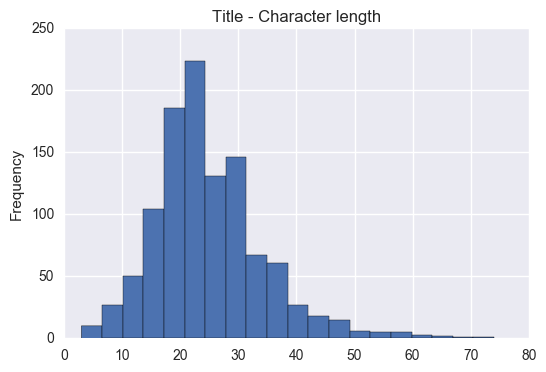

In [55]:
length.title_length.plot(bins=20, kind='hist');
plt.title("Title - Character length");

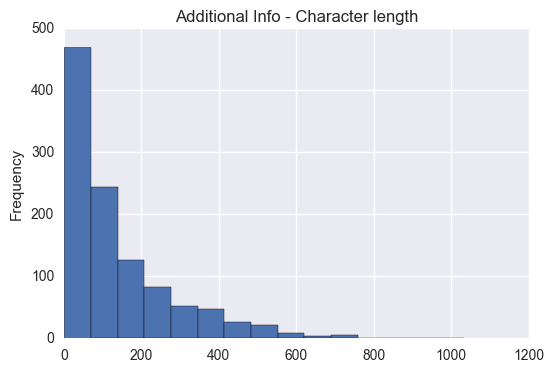

In [56]:
length.additional_info_length.plot(bins=15, kind='hist');
plt.title("Additional Info - Character length");

> We can see that "additional info" is an optional field and that overall length of each of the samples is small.

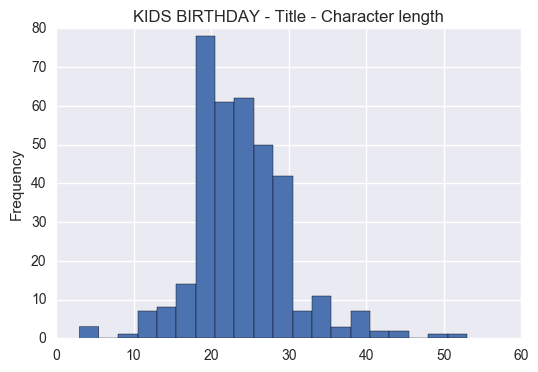

In [57]:
length[length["category"] == 'kids birthday']["title_length"].plot(bins=20, kind='hist');
plt.title("KIDS BIRTHDAY - Title - Character length");

# Preparing Dataset

In [16]:
def prepare_data(df):
    y = df.category
    X = df[['title', 'additional_info']].values 
    print("X:", X.shape, " y:", y.shape)
    return X,y

In [17]:
X, y = prepare_data(g)

X: (1089, 2)  y: (1089,)


In [18]:
def join_columns(X):
    X_joined = []
    for x in X:
        X_joined.append(str(x[0]) + str(" - ") + str(x[1]))
    return np.array(X_joined).reshape(-1, 1)

In [19]:
def correct_type(X):
    X_corrected = []
    for x in X:
        if x == np.nan:
            X_corrected.append("None")
        else:
            X_corrected.append(str(x))
    return np.array(X_corrected).reshape(-1, 1)

In [20]:
X_title = correct_type(X[:,0])
X_additional = correct_type(X[:,1])
X_joined = join_columns(X)
print(X_joined.shape, X_title.shape, X_additional.shape)

(1089, 1) (1089, 1) (1089, 1)


In [21]:
X_joined[4][0]

'vihaan 1st birthday party - we would also like the photographer to take candid shots, use flash lighting and would require amazing snaps to keep for memories.'

In [22]:
X_title[4][0]

'vihaan 1st birthday party'

In [23]:
X_additional[4][0]

'we would also like the photographer to take candid shots, use flash lighting and would require amazing snaps to keep for memories.'

### Split dataset into train and test

I have three sets of data:
+ Set 1: combination of title and additional information
+ Set 2: title
+ Set 3: additional information

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_joined, y, test_size=0.3, stratify=y)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_title, y, test_size=0.3, stratify=y)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_additional, y, test_size=0.3, stratify=y)

In [25]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(762, 1) (327, 1) (762,) (327,)


# Normalization: Stemming vs Lemmatization 

In [27]:
# Spacy for tokenization and lemmatization
en_nlp = spacy.load('en')

In [28]:
# List of NLTK stemmers to the tested 
snowball = nltk.stem.SnowballStemmer("english")
lancaster = nltk.stem.LancasterStemmer()
porter = nltk.stem.PorterStemmer()

In [29]:
def compare_normalization(doc):
    # tokenize document in spacy
    doc_spacy = en_nlp(doc)
    # Lemmatization
    print("Lemmatization:")
    print([token.lemma_ for token in doc_spacy])
    # print tokens found by Porter stemmer
    print("Porter:")
    print([porter.stem(token.norm_.lower()) for token in doc_spacy])
    print("snowball:")
    print([snowball.stem(token.norm_.lower()) for token in doc_spacy])    
    print("lancaster:")
    print([lancaster.stem(token.norm_.lower()) for token in doc_spacy])    

In [30]:
compare_normalization(u"this is an informal reception at our apartment complex before we have a wedding. we would like to spend the first 1-2 hours on portraits of just the two of us at nice spots around our apartment complex or any other ideas you have. we would like some nice portraits. then capture a bit of the event.")

Lemmatization:
['this', 'be', 'an', 'informal', 'reception', 'at', 'our', 'apartment', 'complex', 'before', 'we', 'have', 'a', 'wedding', '.', 'we', 'would', 'like', 'to', 'spend', 'the', 'first', '1', '-', '2', 'hour', 'on', 'portrait', 'of', 'just', 'the', 'two', 'of', 'us', 'at', 'nice', 'spot', 'around', 'our', 'apartment', 'complex', 'or', 'any', 'other', 'idea', 'you', 'have', '.', 'we', 'would', 'like', 'some', 'nice', 'portrait', '.', 'then', 'capture', 'a', 'bit', 'of', 'the', 'event', '.']
Porter:
['thi', 'is', 'an', 'inform', 'recept', 'at', 'our', 'apart', 'complex', 'befor', 'we', 'have', 'a', 'wed', '.', 'we', 'would', 'like', 'to', 'spend', 'the', 'first', '1', '-', '2', 'hour', 'on', 'portrait', 'of', 'just', 'the', 'two', 'of', 'us', 'at', 'nice', 'spot', 'around', 'our', 'apart', 'complex', 'or', 'ani', 'other', 'idea', 'you', 'have', '.', 'we', 'would', 'like', 'some', 'nice', 'portrait', '.', 'then', 'captur', 'a', 'bit', 'of', 'the', 'event', '.']
snowball:
['this'

In [31]:
compare_normalization(u"i would like to have the photographer take a lot of pics of the president (rakesh kumar) mingling with the guests. also, individualized couples and family pics by the fireplace. i would like photos of decorations, desserts, displays etc. i can give more direction once i meet with the photographer.")

Lemmatization:
['i', 'would', 'like', 'to', 'have', 'the', 'photographer', 'take', 'a', 'lot', 'of', 'pic', 'of', 'the', 'president', '(', 'rakesh', 'kumar', ')', 'mingle', 'with', 'the', 'guest', '.', 'also', ',', 'individualized', 'couple', 'and', 'family', 'pic', 'by', 'the', 'fireplace', '.', 'i', 'would', 'like', 'photo', 'of', 'decoration', ',', 'dessert', ',', 'display', 'etc', '.', 'i', 'can', 'give', 'more', 'direction', 'once', 'i', 'meet', 'with', 'the', 'photographer', '.']
Porter:
['i', 'would', 'like', 'to', 'have', 'the', 'photograph', 'take', 'a', 'lot', 'of', 'pic', 'of', 'the', 'presid', '(', 'rakesh', 'kumar', ')', 'mingl', 'with', 'the', 'guest', '.', 'also', ',', 'individu', 'coupl', 'and', 'famili', 'pic', 'by', 'the', 'fireplac', '.', 'i', 'would', 'like', 'photo', 'of', 'decor', ',', 'dessert', ',', 'display', 'etc', '.', 'i', 'can', 'give', 'more', 'direct', 'onc', 'i', 'meet', 'with', 'the', 'photograph', '.']
snowball:
['i', 'would', 'like', 'to', 'have', 'th

> Lemmatization seem to mantain keywords in context. I will use lemmatization on the vectorizers

In [33]:
import re
regexp = re.compile('(?u)\\b\\w\\w+\\b') # regexp used in CountVectorizer

In [34]:
old_tokenizer = en_nlp.tokenizer
# replacing the tokenizer
en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(regexp.findall(string))

In [35]:
def custom_tokenizer(document):
    doc_spacy = en_nlp(document, entity=False, parse=False) 
    return [token.lemma_ for token in doc_spacy]

### Stop words

I used the stop words during the cleanup process

In [36]:
from sklearn.feature_extraction import text 

In [37]:
my_additional_stop_words = ["nan", "test", "fdghjkl", "test2", "dddfgb2v", "etc"]

In [38]:
s_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

# Vectorizers

### Count Vectorizer

In [39]:
count_vect = CountVectorizer(analyzer=u'word', tokenizer=custom_tokenizer, stop_words=s_words, ngram_range=(1,2), min_df=3)

In [40]:
X_train_counts = count_vect.fit_transform(X_train.ravel())
X_test_counts = count_vect.transform(X_test.ravel())
print(X_train_counts.shape, X_test_counts.shape, "Vocabulary size: ", len(count_vect.vocabulary_))

(762, 1099) (327, 1099) Vocabulary size:  1099


### Binary Count Vectorizer

In [41]:
count_vect_bin = CountVectorizer(analyzer=u'word', tokenizer=custom_tokenizer, binary=True, stop_words=s_words, ngram_range=(1,2), min_df=3)

In [42]:
X_train_counts_bin = count_vect_bin.fit_transform(X_train.ravel())
X_test_counts_bin = count_vect_bin.transform(X_test.ravel())
print(X_train_counts_bin.shape, X_test_counts_bin.shape, "Vocabulary size: ", len(count_vect_bin.vocabulary_))

(762, 1099) (327, 1099) Vocabulary size:  1099


### Term Frequency Vectorizer

In [43]:
tf = TfidfTransformer(use_idf=False)
X_train_tf = tf.fit_transform(X_train_counts)
X_test_tf = tf.transform(X_test_counts)
print(X_train_tf.shape, X_test_tf.shape)

(762, 1099) (327, 1099)


### Tf-idf Vectorizer

An even more effective way to vectorize text data is by using Tfidf. In brief, you can multiply the term frequency of the words that compose a document by the inverse document frequency of the word itself (that is, in the number of documents it appears, if logarithmically scaled). This is very handy to highlight words that effectively describe each document, and is a powerful discriminative element among the dataset.

In [44]:
tf_idf = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=s_words, ngram_range=(1,2), min_df=3)

In [45]:
X_train_tfidf = tf_idf.fit_transform(X_train.ravel())
X_test_tfidf = tf_idf.transform(X_test.ravel())
print(X_train_tfidf.shape, X_test_tfidf.shape, "Vocabulary size: ", len(tf_idf.vocabulary_))

(762, 1099) (327, 1099) Vocabulary size:  1099


# Very short texts are likely to have noisy tf–idf values while the binary occurrence info is more stable.

# Building Baseline model

According to Sklearn documentation:
> Inherently multiclass: Naive Bayes, Decision Trees, Random Forests, Nearest Neighbors,  LogisticRegression ('multinomial')

In [47]:
#Baseline models:
models = []
models.append(('MNB', MultinomialNB()))
models.append(('CART', DecisionTreeClassifier())) 
models.append(('KNN', KNeighborsClassifier())) 
models.append(('LR', LogisticRegression(multi_class='multinomial', solver='newton-cg'))) 
models.append(('SVM', LinearSVC())) 

In [48]:
# Test options and evaluation metric
num_folds = 5
seed = 7
scoring = 'accuracy'

In [49]:
def compute_baseline(models, X_train_counts, y_train, num_folds, scoring):
    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=num_folds, random_state=seed)
        cv_results = cross_val_score(model, X_train_counts, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        print("[{}] \t{:.3f} ({:.3f})".format(name, cv_results.mean(), cv_results.std()))

    return names, results

In [50]:
def plot_baseline(names, results, classes=9, order=True, guess=True):
    #sorting prior to plotting
    if order == True:
        rm = np.median(results, axis=1)
        idxs = np.argsort(rm)[::-1]
        names = np.array(names)[idxs]
        r = []
        for i in idxs:
            r.append(results[i])
        results = r   
    fig = plt.figure() 
    plt.title('Algorithm Comparison')
    plt.ylabel("Accuracy Score")
    ax = fig.add_subplot(111) 
    plt.boxplot(results)
    if guess:
        plt.ylim(0,1)
        plt.hlines(y=1/classes, xmin=0, xmax =10, linestyles="--", label='Guessing', color='g')
        plt.legend()
    ax.set_xticklabels(names) 
    plt.show()

In [51]:
def evaluate_features(models, X_train_counts, y_train, num_folds, scoring, guess=True):
    names, results = compute_baseline(models, X_train_counts, y_train, num_folds, scoring)
    plot_baseline(names, results, order=True, classes=len(np.unique(y_train)), guess=guess)

## Evaluating models with each of the different types of vectorizers created in the previous section

[MNB] 	0.585 (0.061)
[CART] 	0.566 (0.041)
[KNN] 	0.499 (0.047)
[LR] 	0.630 (0.046)
[SVM] 	0.604 (0.045)


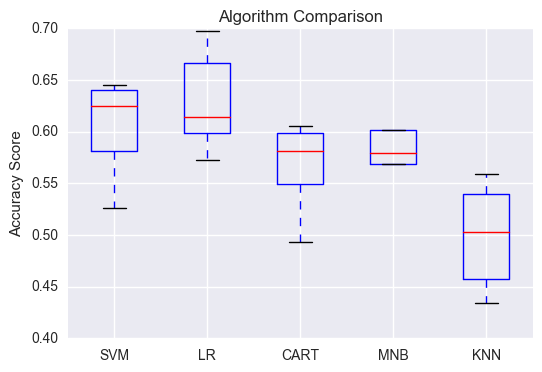

In [134]:
evaluate_features(models, X_train_counts, y_train, num_folds, scoring, guess=False)

> SVM and Logistic Regression do well with a simple count vertorizer

[MNB] 	0.589 (0.062)
[CART] 	0.568 (0.039)
[KNN] 	0.507 (0.041)
[LR] 	0.631 (0.050)
[SVM] 	0.612 (0.045)


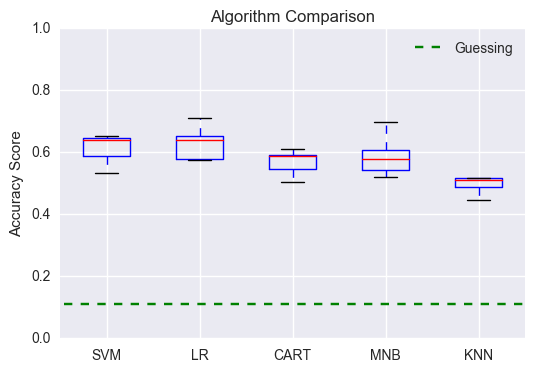

In [135]:
evaluate_features(models, X_train_counts_bin, y_train, num_folds, scoring)

## TermFrequency

[MNB] 	0.500 (0.076)
[CART] 	0.554 (0.026)
[KNN] 	0.404 (0.027)
[LR] 	0.600 (0.071)
[SVM] 	0.631 (0.047)


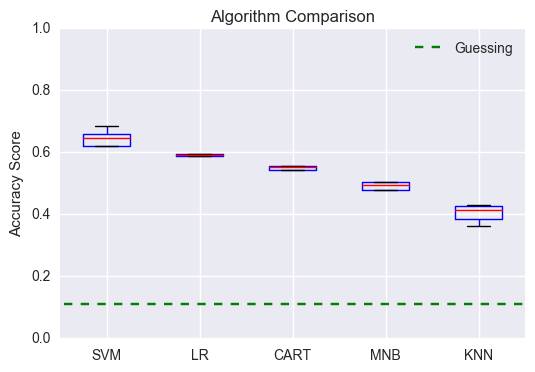

In [136]:
evaluate_features(models, X_train_tf, y_train, num_folds, scoring)

[MNB] 	0.509 (0.075)
[CART] 	0.552 (0.027)
[KNN] 	0.312 (0.040)
[LR] 	0.597 (0.078)
[SVM] 	0.619 (0.036)


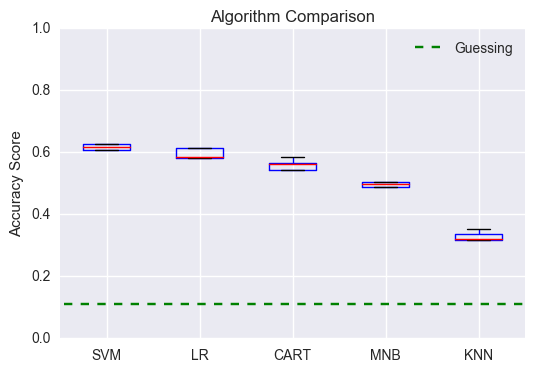

In [55]:
evaluate_features(models, X_train_tfidf, y_train, num_folds, scoring)

> I will proceed to tune the parameters of SVM, LR and MNB

## Emsemble methods

> CART (Decision trees) seem to be performing OK. I am interested in seeing if Random Forest could boost that performance significantly.

In [137]:
# ensembles
ensembles = []
ensembles.append(('AB', AdaBoostClassifier())) 
ensembles.append(('RF', RandomForestClassifier())) 

[AB] 	0.490 (0.066)
[RF] 	0.572 (0.054)


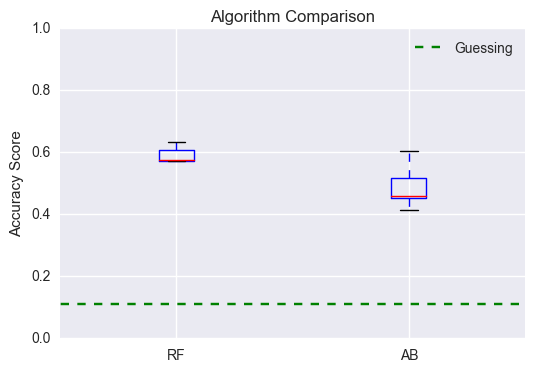

In [138]:
evaluate_features(ensembles, X_train_counts_bin, y_train, num_folds, scoring, guess=True)

[AB] 	0.492 (0.065)
[RF] 	0.571 (0.066)


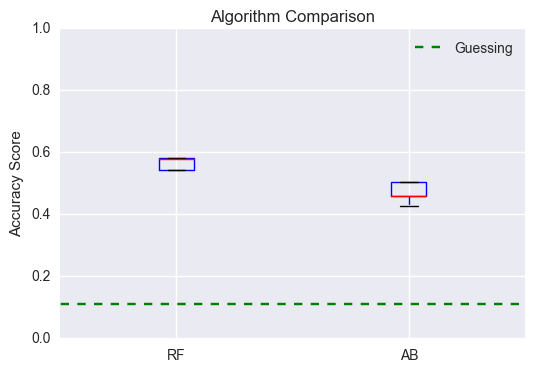

In [139]:
evaluate_features(ensembles, X_train_tf, y_train, num_folds, scoring, guess=True)

[AB] 	0.490 (0.055)
[RF] 	0.570 (0.035)


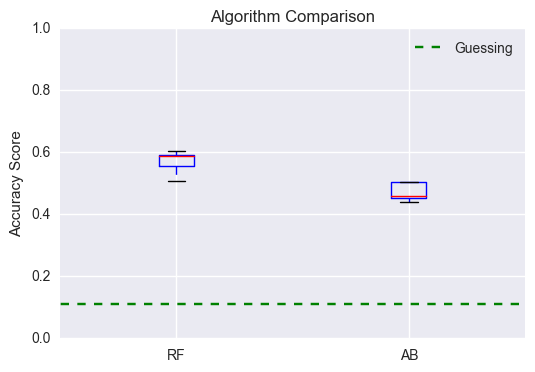

In [140]:
evaluate_features(ensembles, X_train_tfidf, y_train, num_folds, scoring, guess=True)

> The improvement with default parameters is not significant. I will proceed to fine tune the models selected in the previous section.

# Grid-Searching Hyperparameters
+ Logistic Regression
+ Multinomial Naive Bayes
+ Support Vector Machines


## Logistic Regression

In [60]:
lr_pipe = Pipeline([('vect', CountVectorizer(tokenizer= custom_tokenizer, stop_words=s_words)),
                    ('lr', LogisticRegression(multi_class='multinomial', solver='newton-cg'))])

In [61]:
param_grid = {'vect__binary': [True, False],
    'vect__ngram_range': [(1,1),(1,2),(1,3)],
              'vect__min_df': [i for i in range(1,5)],
              'lr__C': [0.01, 0.1, 1, 10, 100],
             'lr__class_weight':['balanced', None],}

In [62]:
grid = GridSearchCV(lr_pipe, 
                    param_grid, 
                    cv=5,
                    verbose=True,
                    scoring='accuracy')
grid.fit(X_train.ravel(), y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:  9.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=frozenset({...ty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'vect__binary': [True, False], 'vect__min_df': [1, 2, 3, 4], 'lr__class_weight': ['balanced', None], 'vect__ngram_range': [(1, 1), (1, 2), (1, 3)], 'lr__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

In [68]:
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.65


In [69]:
print(grid.best_params_)

{'vect__binary': True, 'vect__min_df': 1, 'vect__ngram_range': (1, 1), 'lr__class_weight': None, 'lr__C': 1}


In [70]:
print("Vectorization step:\n{}".format( grid.best_estimator_.named_steps["vect"]))

Vectorization step:
CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=frozenset({'whole', 'whom', 'her', 'hence', 'one', 'seeming', 'between', 'five', 'am', 'she', 'because', 'sometimes', 'though', 'out', 'themselves', 'has', 'them', 'becoming', 'everyone', 'while', 'there', 'by', 'nobody', 'hers', 'also', 'top', 'might', 'amongst', 'three', 'often', 'fire'...', 'namely', 'formerly', 'against', 'must', 'meanwhile', 'ever', 'become', 'everywhere', 'fdghjkl'}),
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function custom_tokenizer at 0x1181311e0>,
        vocabulary=None)


In [71]:
print("Logistic regression step:\n{}".format( grid.best_estimator_.named_steps["lr"]))

Logistic regression step:
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)


In [72]:
pred = grid.predict(X_test.ravel())
print("Classification report on test set for classifier:")
print(classification_report(y_test, pred))  # target_names=news_test.target_names

Classification report on test set for classifier:
                  precision    recall  f1-score   support

     baby shower       0.54      0.70      0.61        10
   company event       0.51      0.80      0.62        56
      conference       0.62      0.53      0.57        15
   kids birthday       0.85      0.90      0.87       108
life celebration       0.64      0.41      0.50        39
           other       0.50      0.41      0.45        22
  portrait shoot       0.61      0.48      0.54        23
   private party       0.41      0.32      0.36        41
         wedding       0.40      0.15      0.22        13

     avg / total       0.63      0.64      0.62       327



In [73]:
accuracy_score(y_test, pred)

0.63608562691131498

> The accuracy on the hold-out set is 0.64%

In [74]:
cm = confusion_matrix(y_test, pred)
print("Confusion matrix:")
print(cm)

Confusion matrix:
[[ 7  0  0  0  0  0  1  2  0]
 [ 0 45  5  0  1  2  1  2  0]
 [ 0  5  8  0  0  1  0  1  0]
 [ 0  6  0 97  1  0  2  2  0]
 [ 2  7  0  5 16  1  1  5  2]
 [ 1  6  0  2  1  9  2  1  0]
 [ 0  6  0  2  1  2 11  0  1]
 [ 3 13  0  7  3  2  0 13  0]
 [ 0  1  0  1  2  1  0  6  2]]


In [142]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    print('Confusion matrix')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [76]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)

In [78]:
v = grid.best_estimator_.named_steps["vect"]
c = grid.best_estimator_.named_steps["lr"]
cls = grid.best_estimator_.named_steps["lr"].classes_

Confusion matrix, without normalization


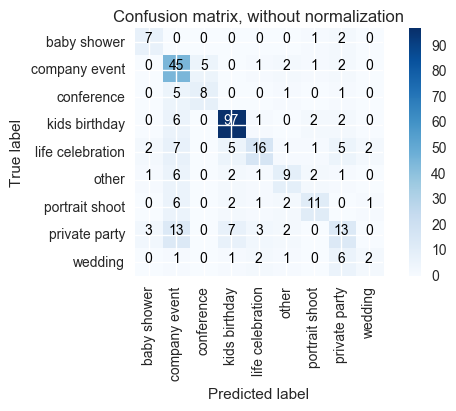

In [79]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=cls,
                      title='Confusion matrix, without normalization')

> It is worth mentioning that category "private party" definition overlaps with "company event" which confuses the model and dirrectly affects accuracy.

### Most informative features

In [80]:
def print_topk(vectorizer, clf, class_labels, n):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top = np.argsort(clf.coef_[i])[-n:]
        print("[{}] - {}".format(class_label,
              ", ".join(feature_names[j] for j in top)))

In [81]:
print_topk(v, c, cls, 5)

[baby shower] - mom, hall, traditional, baby, shower
[company event] - people, shire, event, tour, holiday
[conference] - speaker, conference, schedule, summit, 2016
[kids birthday] - turn, bday, year, 1st, birthday
[life celebration] - portrait, graduation, baptism, proposal, engagement
[other] - guntupalli, 2015, nilisha, warm, prom
[portrait shoot] - portrait, maternity, session, family, headshot
[private party] - party, birthday, dinner, 40th, 50th
[wedding] - enter, small, super, ceremony, wedding


> I used this information to iteratively clean-up the input vectors

## Multinomial Naive Bayes

In [143]:
mnb_pipe = Pipeline([('vect', CountVectorizer(tokenizer= custom_tokenizer, stop_words=s_words)),
                     ('tfidf', TfidfTransformer()),
                    ('mnb', MultinomialNB())])

In [144]:
mnb_param_grid = {'vect__binary': [True, False],
              'vect__ngram_range': [(1,1),(1,2),(1,3)],
              'vect__min_df': [i for i in range(1,5)],
                  'tfidf__use_idf': [True, False],
              'mnb__alpha': [0.01, 0.1, 0.5, 0.7, 1],
             'mnb__fit_prior':[True, False],}

In [145]:
mnb_grid = GridSearchCV(mnb_pipe, 
                    mnb_param_grid, 
                    cv=5,
                    verbose=True,
                    scoring='accuracy')
mnb_grid.fit(X_train.ravel(), y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed: 13.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=frozenset({...inear_tf=False, use_idf=True)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'mnb__alpha': [0.01, 0.1, 0.5, 0.7, 1], 'vect__ngram_range': [(1, 1), (1, 2), (1, 3)], 'tfidf__use_idf': [True, False], 'vect__binary': [True, False], 'mnb__fit_prior': [True, False], 'vect__min_df': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

In [147]:
print("Best cross-validation score: {:.2f}".format(mnb_grid.best_score_))

Best cross-validation score: 0.63


In [148]:
print(mnb_grid.best_params_)

{'mnb__alpha': 0.5, 'vect__ngram_range': (1, 2), 'vect__binary': True, 'tfidf__use_idf': False, 'mnb__fit_prior': False, 'vect__min_df': 3}


In [149]:
print("Multinomial Naive Bayes step:\n{}".format( mnb_grid.best_estimator_.named_steps["mnb"]))

Multinomial Naive Bayes step:
MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)


In [150]:
mnb_pred = mnb_grid.predict(X_test.ravel())
print("Classification report on test set for classifier:")
print(classification_report(y_test, mnb_pred))  # target_names=news_test.target_names

Classification report on test set for classifier:
                  precision    recall  f1-score   support

     baby shower       0.29      0.70      0.41        10
   company event       0.60      0.71      0.65        56
      conference       0.50      0.80      0.62        15
   kids birthday       0.82      0.91      0.86       108
life celebration       0.62      0.54      0.58        39
           other       0.54      0.32      0.40        22
  portrait shoot       0.57      0.57      0.57        23
   private party       0.47      0.20      0.28        41
         wedding       0.60      0.23      0.33        13

     avg / total       0.64      0.64      0.62       327



In [151]:
accuracy_score(y_test, mnb_pred)

0.63914373088685017

In [152]:
# Compute confusion matrix
mnb_cm = confusion_matrix(y_test, mnb_pred)
np.set_printoptions(precision=2)

Confusion matrix


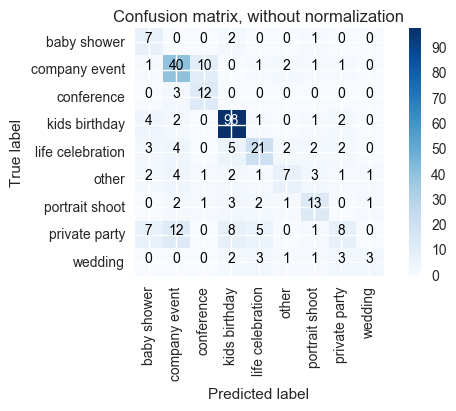

In [153]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(mnb_cm, classes=cls,
                      title='Confusion matrix, without normalization')

### Feature importance

In [155]:
v_mnb = mnb_grid.best_estimator_.named_steps["vect"]
c_mnb = mnb_grid.best_estimator_.named_steps["mnb"]
cls_mnb = mnb_grid.best_estimator_.named_steps["mnb"].classes_

In [156]:
print_topk(v_mnb, c_mnb, cls_mnb, 5)

[baby shower] - event, shot, shower, baby shower, baby
[company event] - 2015, party, photo, shot, event
[conference] - schedule, conference, shot, speaker, 2016
[kids birthday] - birthday party, 1st birthday, 1st, party, birthday
[life celebration] - event, shot, like, engagement, party
[other] - event, prom, 2015, party, shot
[portrait shoot] - session, portrait, shot, photo, family
[private party] - family, shot, photo, birthday, party
[wedding] - shot, photographer, photo, ceremony, wedding


> There are common elements across the classes. This is a good ilustration of how **"photo"** or **"shot"** should be included in the <u>stop_word</u> list

## Support Vector Machines

In [159]:
svm_pipe = Pipeline([('vect', CountVectorizer(tokenizer= custom_tokenizer, stop_words=s_words)),
                     ('tfidf', TfidfTransformer()),
                    ('svm', SVC(kernel='linear'))])

In [160]:
svm_param_grid = {'vect__binary': [True, False],
              'vect__ngram_range': [(1,1),(1,2)],
              'vect__min_df': [i for i in range(1,5)],
                  'tfidf__use_idf': [True, False],
              'svm__C': [ 0.7, 1, 10],
             'svm__kernel':['rbf', 'linear'],
                 'svm__class_weight': ['balanced', None]}

In [161]:
svm_grid = GridSearchCV(svm_pipe, 
                    svm_param_grid, 
                    cv=5,
                    verbose=True,
                    scoring='accuracy')
svm_grid.fit(X_train.ravel(), y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=1)]: Done 1920 out of 1920 | elapsed: 14.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=frozenset({...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'svm__kernel': ['rbf', 'linear'], 'tfidf__use_idf': [True, False], 'vect__ngram_range': [(1, 1), (1, 2)], 'svm__C': [0.7, 1, 10], 'vect__binary': [True, False], 'vect__min_df': [1, 2, 3, 4], 'svm__class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

In [162]:
print("Best cross-validation score: {:.2f}".format(svm_grid.best_score_))

Best cross-validation score: 0.66


In [163]:
print(svm_grid.best_params_)

{'svm__kernel': 'linear', 'vect__ngram_range': (1, 1), 'svm__class_weight': 'balanced', 'tfidf__use_idf': True, 'vect__binary': True, 'svm__C': 0.7, 'vect__min_df': 1}


In [164]:
print("Support Vector Machine step:\n{}".format( svm_grid.best_estimator_.named_steps["svm"]))

Support Vector Machine step:
SVC(C=0.7, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [166]:
svm_pred = svm_grid.predict(X_test.ravel())
accuracy_score(y_test, svm_pred)

0.64525993883792054

In [167]:
print("Classification report on test set for classifier:")
print(classification_report(y_test, svm_pred))

Classification report on test set for classifier:
                  precision    recall  f1-score   support

     baby shower       0.50      0.60      0.55        10
   company event       0.50      0.73      0.59        56
      conference       0.56      0.67      0.61        15
   kids birthday       0.92      0.86      0.89       108
life celebration       0.61      0.51      0.56        39
           other       0.50      0.41      0.45        22
  portrait shoot       0.65      0.65      0.65        23
   private party       0.39      0.29      0.33        41
         wedding       0.56      0.38      0.45        13

     avg / total       0.65      0.65      0.64       327



In [175]:
# Compute confusion matrix
svm_cm = confusion_matrix(y_test, svm_pred)
np.set_printoptions(precision=2)

Confusion matrix, without normalization


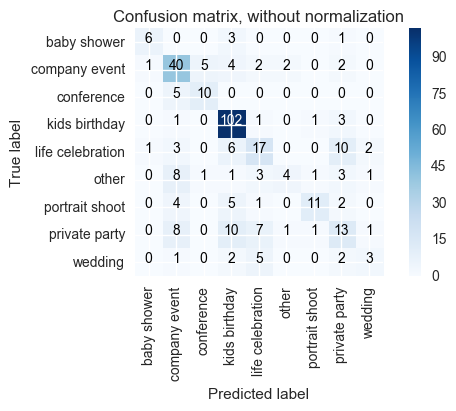

In [176]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(mnb_cm, classes=cls,
                      title='Confusion matrix, without normalization')

### Feature Importance

In [201]:
v_svm = svm_grid.best_estimator_.named_steps["vect"]
c_svm = svm_grid.best_estimator_.named_steps["svm"]
cls_svm = svm_grid.best_estimator_.named_steps["svm"].classes_

In [197]:
print_topk(v_svm, c_svm, cls_svm, 5)

[baby shower] - 
[company event] - 
[conference] - 
[kids birthday] - 
[life celebration] - 
[other] - 
[portrait shoot] - 
[private party] - 
[wedding] - 


In [210]:
c_svm.coef_.toarray().shape

(36, 2751)

> For multiclass problems, the coefficients are a matrix with all 1-vs-1 classifiers. The layout of the coefficients in the multiclass case is somewhat **non-trivial** as per Sklearn documentation. 
+ [n_class-1, n_SV]
http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# Finalize model: Use Logistic Regression to recommend top 3 categories

After fine tuning the parameters of each of the models it became clear that the performance of SVM is superior (F1=0.64) as compared to LR (F1=0.62) and MNB(F1=0.62). Nonetheless, the improvement of performance comes at the cost of interpretability of feature importance and a high complexity of parameters.
> I will use Logistic Regression and use top k predictions to boost the accuracy of the model.

### Update prediction list
If correct category is within the top k categories pick coorect category, else pick first item in top k categories.

In [268]:
def multiplek(y_test, topk):
    multik = []
    for i, score in enumerate(y_test):
        if y_test[i] in topk[i]:
            multik.append(y_test[i])
        else:
            multik.append(topk[i][0])
    return multik

### Predicting top 3 categories

Top 3 categories are the top 3 categories with the highest probability.

In [121]:
pred = grid.predict(X_test.ravel())  # predicts a category
p_prob = grid.predict_proba(X_test.ravel()) # predicts the probabilities of each category

In [85]:
idxs = np.argsort(p_prob[0])[::-1] # sorts probabilities in descending order

In [88]:
print(grid.best_estimator_.named_steps["lr"].classes_[idxs][:3])

['kids birthday' 'private party' 'life celebration']


The function below brings all the steps above so it can be applied to the X_test set.

In [91]:
def topk_scored(model,step_name X_test, k):
    results = []
    p_prob = model.predict_proba(X_test)
    for pred in p_prob:
        idxs = np.argsort(pred)[::-1]
        results.append(model.best_estimator_.named_steps[step_name].classes_[idxs][:k])
    return results

In [93]:
pps = topk_scored(grid,"lr", X_test.ravel(), 3)

The function below marks the result as positive if the correct category is within topk.

In [95]:
def scoring_multiplek(y_test, topk):
    result = 0
    l = len(y_test)
    for i, score in enumerate(y_test):
        if y_test[i] in topk[i]:
            result += 1
    return result/l

In [120]:
adjusted_score = scoring_multiplek(y_test.values, pps)
adjusted_score

0.8593272171253823

> By selecting the top 3 categories, the <u>accuracy score</u> using Logistic Regression goes **from %64 to 86%.**

### Display example of predicted top 3 categories

In [99]:
X_test[:3]

array([[ "lucas immanuel's ist birthday and baby dedication - kindly capture this precious moment, as we celebrate a milestone for our son:-) "],
       [ 'kurt and maty engangement - engagement photos, just me and fiance. would like to take shots at various places around campus.'],
       [ 'konica minolta anaheim demo - we will be demo-ing certain items including flying a drone outside']], 
      dtype='<U1054')

In [100]:
y_test[:3]

805     kids birthday   
1063    life celebration
663     other           
Name: category, dtype: object

In [101]:
pps[:3]

[array(['kids birthday', 'private party', 'life celebration'], dtype=object),
 array(['life celebration', 'private party', 'company event'], dtype=object),
 array(['company event', 'private party', 'portrait shoot'], dtype=object)]

In [116]:
# Dataframe to review 3-category predictions
cont = list(zip(X_test,y_test.values, pps))
cols = ["Input", "Input Category", "Predicted Categories"]
results_df = pd.DataFrame(cont ,columns=cols)

In [117]:
results_df.head()

,Input,Input Category,Predicted Categories
0,"[lucas immanuel's ist birthday and baby dedication - kindly capture this precious moment, as we celebrate a milestone for our son:-) ]",kids birthday,"[kids birthday, private party, life celebration]"
1,"[kurt and maty engangement - engagement photos, just me and fiance. would like to take shots at various places around campus.]",life celebration,"[life celebration, private party, company event]"
2,[konica minolta anaheim demo - we will be demo-ing certain items including flying a drone outside],other,"[company event, private party, portrait shoot]"
3,"[16ntc headshots - headshots for guests at conference. schedule: wed, mar 23 - 12:00 - 1:30, thu, mar 24 - 12:00 - 1:30, 3:00 - 5:00, fri, mar 25 - 12:00 - 1:30]",conference,"[company event, conference, portrait shoot]"
4,[the big c's cal vs. ucla game watch party - a mixture of candid shots and individual/group shots if guests would like.],private party,"[life celebration, private party, company event]"


In [118]:
results_df.tail()

,Input,Input Category,Predicted Categories
322,[tori & aric's wedding shower - co-ed wedding shower],life celebration,"[wedding, private party, life celebration]"
323,"[alex & anya's magic 9th! - twins 9th birthday party. i want pictures of my kids engaged with other kids, when blowing candles, cake etc.]",kids birthday,"[kids birthday, private party, life celebration]"
324,"[tara turns one - baby shots with parents, the cakes and just a lot of happy smiles :d]",kids birthday,"[kids birthday, baby shower, wedding]"
325,[rachana graduation/ 75th birthday - will inform additional info as the event comes closer],private party,"[kids birthday, private party, life celebration]"
326,[prisha's 1st b'day - i would need a photographer experienced with kid's 1st b'day party. also in the beginning of the event i would need some professional shots of the baby and my family. main focus should be on the baby's professional pictures as well as the family pics.],kids birthday,"[kids birthday, portrait shoot, private party]"


In [119]:
sc = scoring_multiplek(y_test.values, pps)
sc

0.8593272171253823

# Implementation of Top 3 category recomendations

The implementation of Logistic Regression with top 3 categories would look like the mockup below:

<img src='result.png'>

In [111]:
x = "new on twitter - shots of the keynote speakers, the panel members and the audiences reactions, as well as while people network. posed are fine but candid photos are preferred. the photographer will need to check in on the first floor with building security and say s/he is visiting twitter. security will send s/he to the 9th floor where they will check in with reception."

In [168]:
example = grid.predict_proba(x)
ex_idxs = np.argsort(example[0])[::-1]
print(grid.best_estimator_.named_steps["lr"].classes_[ex_idxs][:3])

['company event', 'life celebration', 'conference']


> The correct category as in the dataset is "company event"